In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Import NLTK and download the data

In [2]:
import nltk
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Plamen\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

# Load Twitter data

In [3]:
from nltk.corpus import twitter_samples
tweets_pos = twitter_samples.strings('positive_tweets.json')     #  5000
tweets_neg = twitter_samples.strings('negative_tweets.json')     #  5000
tweets_all = tweets_pos + tweets_neg                             # 10000

In [4]:
labels_pos = np.ones ((len(tweets_pos),1), dtype=np.int8)  # positive labels (1)
labels_neg = np.zeros((len(tweets_neg),1), dtype=np.int8)  # negative labels (0)
labels_all = np.append(labels_pos,labels_neg)              # all labels

In [5]:
pd.DataFrame(data={'tweet':tweets_all,'label':labels_all}).head(10)

,tweet,label
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1
1,@Lamb2ja Hey James! How odd :/ Please call our...,1
2,@DespiteOfficial we had a listen last night :)...,1
3,@97sides CONGRATS :),1
4,yeaaaah yippppy!!! my accnt verified rqst has...,1
5,@BhaktisBanter @PallaviRuhail This one is irre...,1
6,We don't like to keep our lovely customers wai...,1
7,"@Impatientraider On second thought, there’s ju...",1
8,"Jgh , but we have to go to Bayan :D bye",1
9,"As an act of mischievousness, am calling the E...",1


# Test train split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets_all, labels_all, test_size=0.25, random_state=243824)
len(X_train), len(X_test), len(y_train), len(y_test)

(7500, 2500, 7500, 2500)

# Process

## 1) Tokenize

In [7]:
TweetTokenizer?

Object `TweetTokenizer` not found.


In [8]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
X_train_tok = [tokenizer.tokenize(tweet) for tweet in X_train]


In [9]:
n = 47
X_train[n],X_train_tok[n]

("@hawkins_g omg you're so mean, he's fine :(",
 ['omg', "you're", 'so', 'mean', ',', "he's", 'fine', ':('])

In [10]:
X_train[89]

'@TOBMAST3R @inspchin @koeitecmoeurope @TanikoHorigome @GoldxFierce @Kronin1 @Addictrian @chako33 @MatthewRumple thx Tobi-bro! :D'

In [11]:
X_train_tok[89]

['thx', 'tobi-bro', '!', ':D']

## 2) Remove stopwords

In [12]:
from nltk.corpus import stopwords
swords = stopwords.words('english')

X_train_tok_nostop = []
for tweet in X_train_tok:
    words = [word for word in tweet if word not in swords]
    X_train_tok_nostop.append(words)

In [13]:
X_train_tok_nostop[89]

['thx', 'tobi-bro', '!', ':D']

## 2) Stemming

In [14]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

X_train_tok_nostop_stem = []
for tweet in X_train_tok_nostop:
    words = [stemmer.stem(word) for word in tweet]
    X_train_tok_nostop_stem.append(words)

In [15]:
X_train_tok_nostop_stem[89]

['thx', 'tobi-bro', '!', ':d']


# Put it all into a function

In [16]:
def preprocess_text(tweets):

    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    stemmer = PorterStemmer()
    swords = stopwords.words('english')

    X = []
    for tweet in tweets:
        tokens = tokenizer.tokenize(tweet)
        X.append([stemmer.stem(word) for word in tokens if word not in swords]) 
        
    return X

In [17]:
X_train_pp = preprocess_text(X_train)

# Word frequencies

In [18]:
unique_words = set()
for tweet in X_train_pp:
    unique_words.update(tweet)
len(unique_words)

10223

In [19]:
words_pos = []
words_neg = []

for tweet, label in zip(X_train_pp,y_train):
    if label==0:
        words_neg.extend(tweet)
    else:
        words_pos.extend(tweet)
        
unique_words = np.array(list(unique_words))
words_pos = np.array(words_pos)
words_neg = np.array(words_neg)

print(words_pos[:6])
print(words_neg[:6])

['stat' 'day' 'arriv' '.' '1' 'new']
['one' 'want' 'go' 'ant' 'man' ':(']


In [20]:
len(words_pos) + len(words_neg)

61485

In [21]:
word_count = { w: [0,0] for w in unique_words }
for word in words_pos:
    word_count[word][1] += 1
for word in words_neg:
    word_count[word][0] += 1

In [22]:
word_count_matrix = np.array([val for key,val in word_count.items()])

ind_neg = np.argsort(word_count_matrix[:,0])
ind_pos = np.argsort(word_count_matrix[:,1])

print(unique_words[ind_neg[-4:]])
print(unique_words[ind_pos[-4:]])

word_count[':(']

['!' '.' '(' ':(']
[',' '.' '!' ':)']


[3442, 1]

In [23]:
word_count['.']

[813, 980]

# Plot a sample

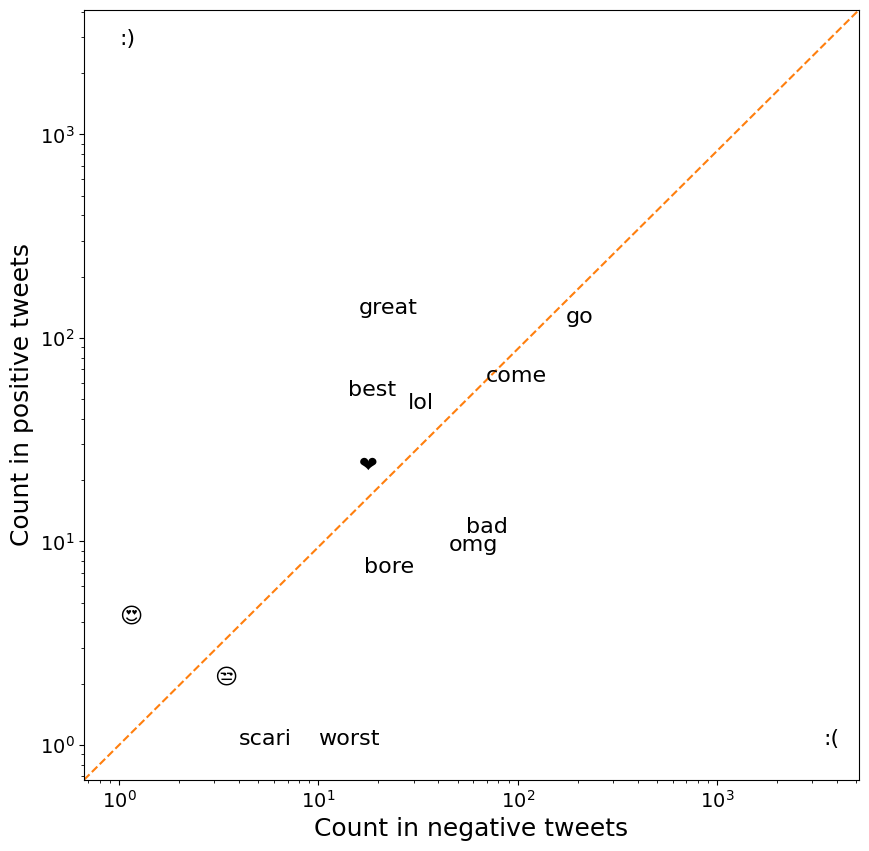

In [24]:
keys = ['❤', '😍', '😒', ':)', ':(','great','bad','scari','bore','best','worst','omg','lol','come','go']\

A = np.array([word_count[key] for key in keys])

plt.figure(figsize=(10,10))
plt.loglog(A[:,0],A[:,1],'.',markersize=0)  
xlim = plt.xlim()
ylim = plt.ylim()
plt.loglog(xlim,ylim,'--')
plt.xlim(xlim)
plt.ylim(ylim)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel("Count in positive tweets", fontsize=18)
plt.xlabel("Count in negative tweets", fontsize=18)

for i in range(0, len(keys)):
    plt.annotate(keys[i], A[i,:], fontsize=16)

# Full bag of words

In [25]:
bow_matrix_train = np.zeros((len(X_train_pp),len(unique_words)))
for i, tweet in enumerate(X_train_pp):
    for word in tweet:
        bow_matrix_train[i,unique_words==word] += 1

In [26]:
np.sum(bow_matrix_train!=0)/np.prod(bow_matrix_train.shape)

0.0007451302618279044

In [27]:
df = pd.DataFrame(data=bow_matrix_train,columns=unique_words)
df.head(10)

,aboard,brows,http://t.co/ezrfqqlzxc,unsettl,flat,exo,t___t,crazi,. ...,mark',...,bonilla,afraid,victori,worth,nicest,heechul,tammirossm,http://t.co/clwnnmfv0d,https://t.co/nj0ziq14i,31
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Test data

In [28]:
X_test_pp = preprocess_text(X_test)
bow_matrix_test = np.zeros((len(X_test_pp),len(unique_words)))
for i, tweet in enumerate(X_test_pp):
    for word in tweet:
        if word in unique_words:
            bow_matrix_test[i,unique_words==word] += 1

# Naive Bayes

In [29]:
alpha = 1 # smooting fact
M = bow_matrix_train.shape[1]

# indices of positive tweets
ind_pos = y_train==1

# Word count for each term i in positive and negative tweets
N_pos_i = bow_matrix_train[ ind_pos,:].sum(axis=0)
N_neg_i = bow_matrix_train[~ind_pos,:].sum(axis=0)

# Total word count in positive and negative tweets
N_pos = N_pos_i.sum()
N_neg = N_neg_i.sum()

# Coefficients for positive and negative classes
logp_pos_i = np.log( (N_pos_i+alpha)/(N_pos+M*alpha) )
logp_neg_i = np.log( (N_neg_i+alpha)/(N_neg+M*alpha) )

# Intercepts for positive and negative classes
logp_pos = np.log( N_pos/(N_pos + N_neg) )
logp_neg = np.log( N_neg/(N_pos + N_neg) )

print(logp_pos_i)

[ -9.54218286  -9.94764797 -10.64079515 ...  -9.94764797 -10.64079515
 -10.64079515]


In [30]:
naive_bayes = MultinomialNB(alpha=1.0, fit_prior=False).fit(bow_matrix_train,y_train)

In [31]:
print(naive_bayes.feature_log_prob_[1])

[ -9.54218286  -9.94764797 -10.64079515 ...  -9.94764797 -10.64079515
 -10.64079515]


In [32]:
naive_bayes.score(bow_matrix_test, y_test)

0.998

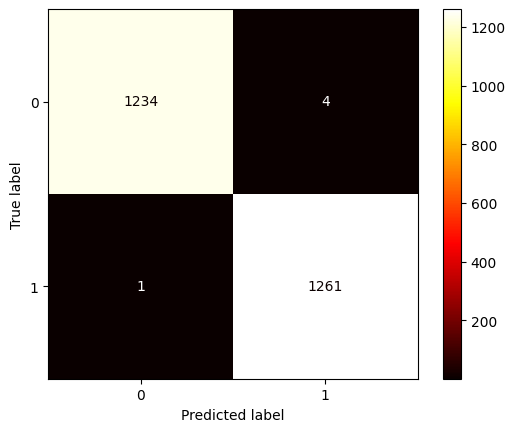

In [33]:
ConfusionMatrixDisplay.from_estimator(naive_bayes, bow_matrix_test, y_test, cmap='hot')

# Logistic regression

In [34]:
lr_full = LogisticRegression().fit(bow_matrix_train,y_train)

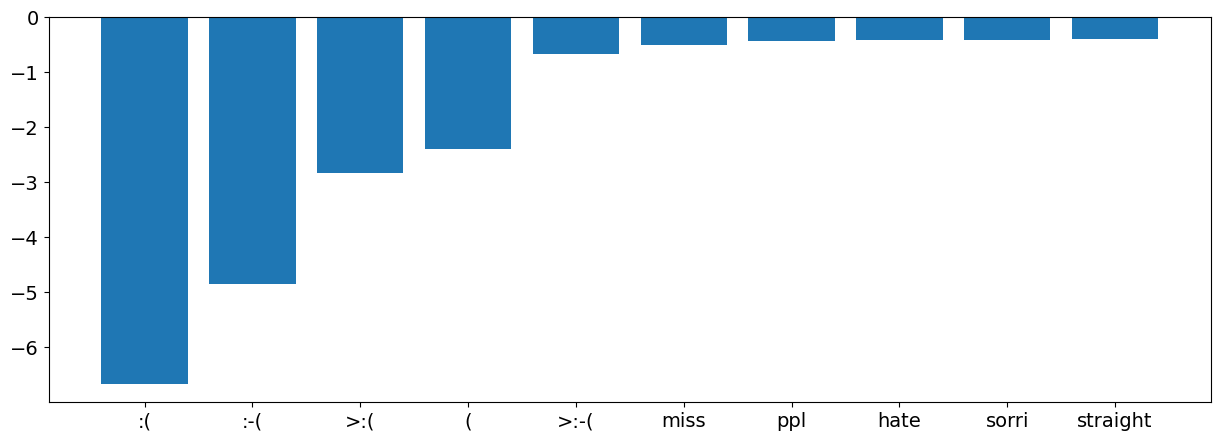

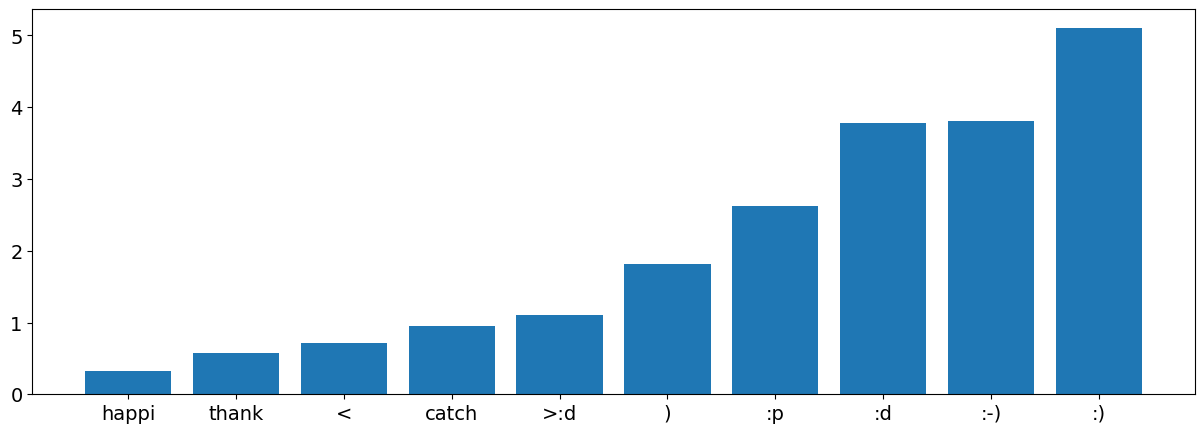

In [35]:
ind = np.argsort(lr_full.coef_[0])

n = 10
plt.figure(figsize=(15,5))
plt.bar([unique_words[i] for i in ind[:n]], lr_full.coef_[0,ind[:n]])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.figure(figsize=(15,5))
plt.bar([unique_words[i] for i in ind[-n:]], lr_full.coef_[0,ind[-n:]])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

In [36]:
lr_full.score(bow_matrix_test, y_test)

0.9992

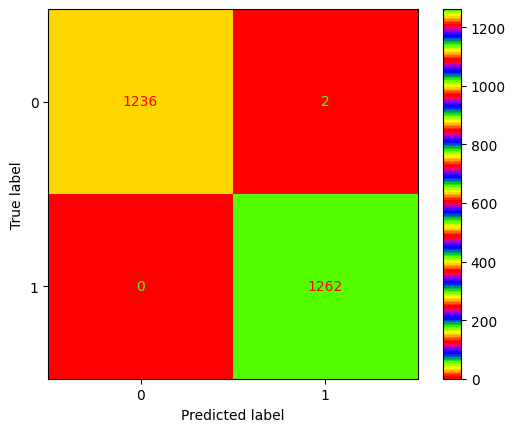

In [37]:
ConfusionMatrixDisplay.from_estimator(lr_full, bow_matrix_test, y_test, cmap='prism')

# Reduced bag of words (2 best features)

In [38]:
keep_words = [':(', ':)']
bow_matrix_train = np.zeros((len(X_train_pp),len(keep_words)))
for i, tweet in enumerate(X_train_pp):
    for word in tweet:
        if word in keep_words:
            bow_matrix_train[i,keep_words.index(word)] += 1
            
# throw away tweets with none of these features
ind_has_feat = bow_matrix_train.sum(axis=1)>0
bow_matrix_train_red = bow_matrix_train[ind_has_feat,:]
y_train_red = y_train[ind_has_feat]

bow_matrix_train_red.shape

(5976, 2)

In [39]:
np.sum(bow_matrix_train!=0)/np.prod(bow_matrix_train.shape)

0.3984

# Reduced test data

In [40]:
bow_matrix_test = np.zeros((len(X_test_pp),len(keep_words)))
for i, tweet in enumerate(X_test_pp):
    for word in tweet:
        if word in keep_words:
            bow_matrix_test[i,keep_words.index(word)] += 1
            
# throw away tweets with none of these features
ind_has_feat = bow_matrix_test.sum(axis=1)>0
bow_matrix_test_red = bow_matrix_test[ind_has_feat,:]
y_test_red = y_test[ind_has_feat]

sum(~ind_has_feat), bow_matrix_test_red.shape

(509, (1991, 2))

# Reduced logistic regression

In [41]:
lr_red = LogisticRegression()
lr_red.fit(bow_matrix_train_red,y_train_red)
lr_red.score(bow_matrix_test_red, y_test_red)

0.9994977398292315

In [54]:
MultinomialNB(alpha=1.0, fit_prior=False).fit(bow_matrix_train_red,y_train_red).score(bow_matrix_test_red, y_test_red)

0.9994977398292315

In [43]:
from matplotlib import colormaps

In [44]:
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

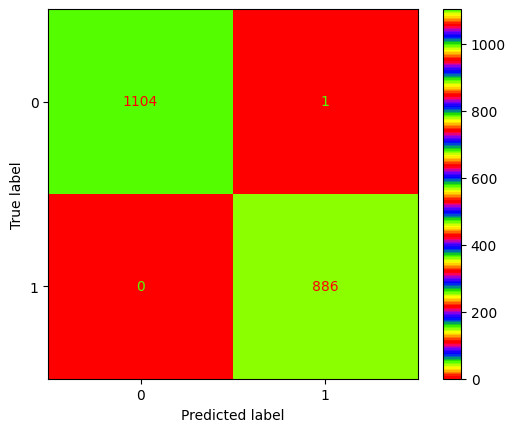

In [45]:
ConfusionMatrixDisplay.from_estimator(lr_red, bow_matrix_test_red, y_test_red, cmap='prism')

# Words only

In [46]:
alpha_words = [word for word in unique_words if word.isalpha()]
len(alpha_words), len(unique_words)

(7096, 10223)

## Train and test data

In [47]:
bow_matrix_train = np.zeros((len(X_train_pp),len(alpha_words)))
for i, tweet in enumerate(X_train_pp):
    for word in tweet:
        if word in alpha_words:
            bow_matrix_train[i,alpha_words.index(word)] += 1
            
            
# throw away tweets with none of these features
ind_has_feat = bow_matrix_train.sum(axis=1)>0
bow_matrix_train_words = bow_matrix_train[ind_has_feat,:]
y_train_words = y_train[ind_has_feat]

In [48]:
bow_matrix_test = np.zeros((len(X_test_pp),len(alpha_words)))
for i, tweet in enumerate(X_test_pp):
    for word in tweet:
        if word in alpha_words:
            bow_matrix_test[i,alpha_words.index(word)] += 1
            
# throw away tweets with none of these features
ind_has_feat = bow_matrix_test.sum(axis=1)>0
bow_matrix_test_words = bow_matrix_test[ind_has_feat,:]
y_test_words = y_test[ind_has_feat]

sum(~ind_has_feat), bow_matrix_test_red.shape

(82, (1991, 2))

## Logistic regression

In [49]:
lr_alpha = LogisticRegression()
lr_alpha.fit(bow_matrix_train_words,y_train_words)
lr_alpha.score(bow_matrix_test_words, y_test_words)

0.7377998345740281

In [50]:
MultinomialNB(alpha=1.0, fit_prior=False) \
    .fit(bow_matrix_train_words,y_train_words) \
    .score(bow_matrix_test_words, y_test_words)

0.7460711331679074

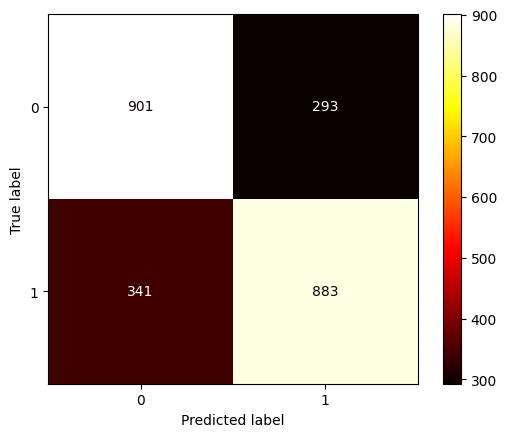

In [51]:
ConfusionMatrixDisplay.from_estimator(lr_alpha, bow_matrix_test_words, y_test_words, cmap='hot')

In [52]:
ind = np.argsort(lr_alpha.coef_[0])
print([alpha_words[i] for i in ind[:5]])
print([alpha_words[i] for i in ind[-5:]])

['sad', 'miss', 'sorri', 'shame', 'aw']
['happi', 'goodnight', 'welcom', 'thank', 'fback']


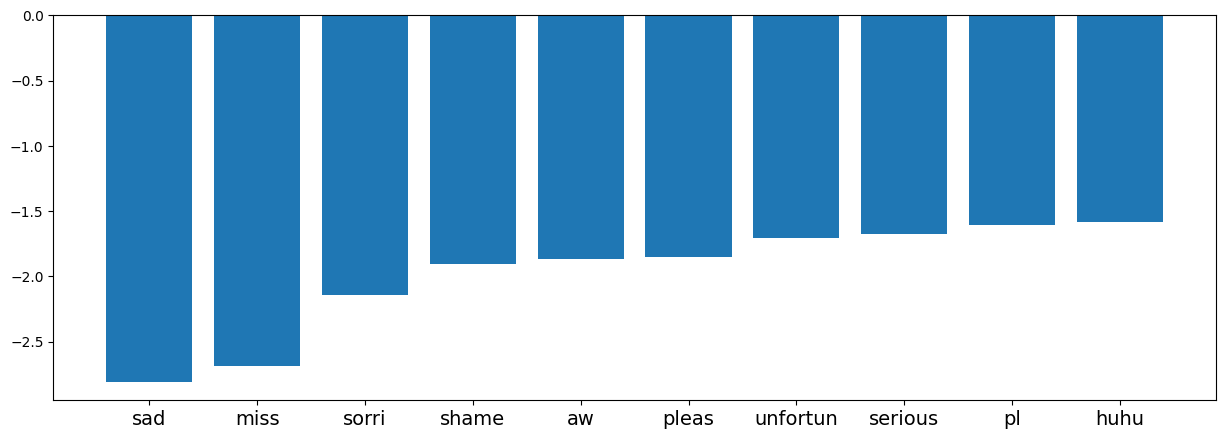

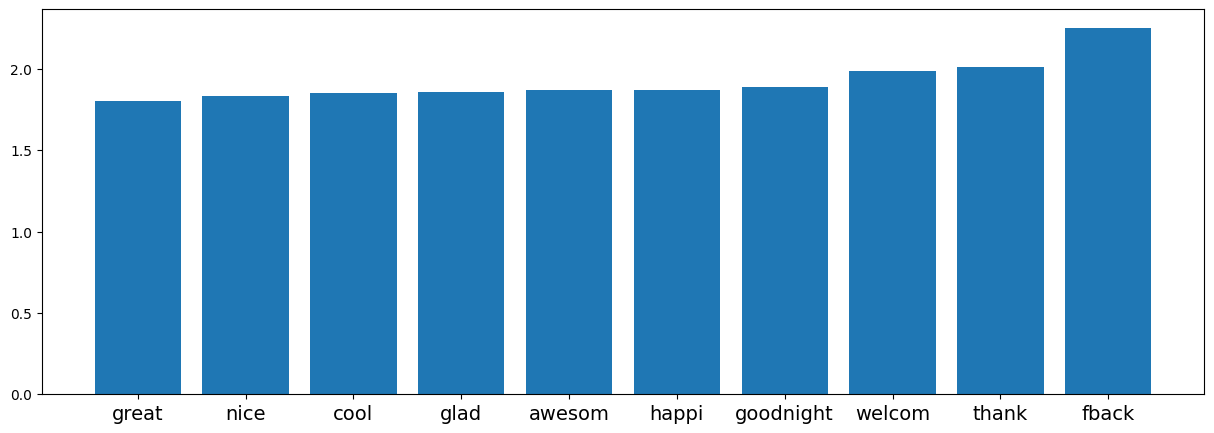

In [53]:

n = 10
plt.figure(figsize=(15,5))
plt.bar([alpha_words[i] for i in ind[:n]], lr_alpha.coef_[0,ind[:n]])
plt.xticks(fontsize=14)

plt.figure(figsize=(15,5))
plt.bar([alpha_words[i] for i in ind[-n:]], lr_alpha.coef_[0,ind[-n:]])
plt.xticks(fontsize=14)
plt.show()

# TF IDF